In [1]:
import numpy as np
from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy.io import ascii, fits
from scipy.interpolate import interp1d

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from fconvo import *

###Plot formatting commands
plt.rc('figure', figsize=(10.0, 7.1)) #bigger figures
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif','size':20, 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

<h1>Example 1: rebin the spectrum of a SWIRE template onto a new grid and compare with SciPy results</h1>

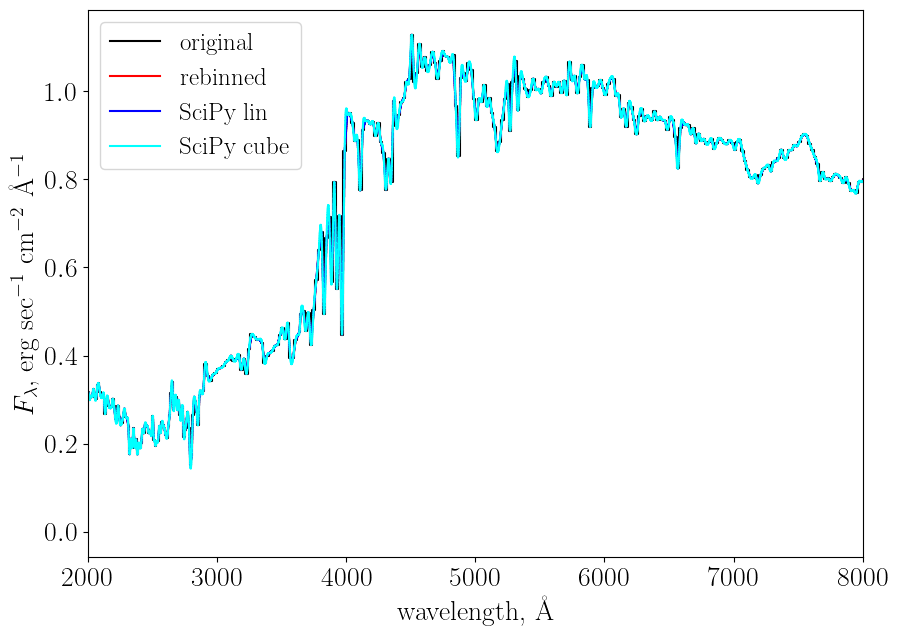

In [2]:
# let's show an example
data = ascii.read("SWIRE/Arp220_template_norm.sed") 
# SWIRE readme file states that the first column is wavelength in Angstroms and the second is flux density Flambda
data.rename_column('col1', 'wv')
data.rename_column('col2', 'flambda')
# let's rebin onto a new grid of optical wavelengths and show the plot:
new_wv=np.arange(2000,8000)
(new_flambda, new_flag)=rebin(data['wv'], data['flambda'], new_wv)
# same but using the scipy interpolation function
interp_lin = interp1d(data['wv'], data['flambda'])
interp_quad = interp1d(data['wv'], data['flambda'], kind='quadratic')
interp_cube = interp1d(data['wv'], data['flambda'], kind='cubic')

# show original and interpolated
plt.step(data['wv'],data['flambda'],where='mid',color='black',label='original')
plt.step(new_wv,new_flambda,where='mid',color='red',label='rebinned')
plt.step(new_wv,interp_lin(new_wv),color='blue',label='SciPy lin')
plt.step(new_wv,interp_cube(new_wv),color='cyan',label='SciPy cube')
plt.xlim((2000,8000))
plt.legend(loc='upper left')
plt.xlabel(r'wavelength, \AA')
plt.ylabel(r'$F_{\lambda}$, erg sec$^{-1}$ cm$^{-2}$ \AA$^{-1}$')
plt.show()

<h2>Introduction to proper flux averaging: photon counters vs energy counters:</h2>

<p>https://www.astro.ljmu.ac.uk/~ikb/research/mags-fluxes/
    
<p>For the filters provided with this distribution, the type of filter is entered at the top of the transmission curve, with reference if available. Here is the summary: 
    
<p>Transmission flag:
<br>tflag=1 for photon counter or a quantum efficiency transmission curve
<br>tflag=0 for energy counter or bolometer

<p>For SDSS, use tflag=1: http://classic.sdss.org/dr2/products/general/edr_html/node25.html 
<br>(the svo2 filter collection appears to give the wrong information about the SDSS filters)

<p>For WISE, Spitzer and Herschel filters use tflag=0. 
<br>WISE: http://wise2.ipac.caltech.edu/docs/release/prelim/expsup/sec4_3g.html [Important: the filter curves provided with this distribution for WISE are energy-counting, so use tflag=0. Photon-counting filter curves for WISE are also available -- for example, here: https://www.astro.ucla.edu/~wright/WISE/passbands.html, and if you download and use these ones instead, then use tflag=1 with them.]
<br>Spitzer IRAC: https://ui.adsabs.harvard.edu/abs/2005PASP..117..978R/abstract equation 9
<br>Spitzer MIPS: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
<br>Herschel SPIRE: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Herschel/SPIRE.PSW&&mode=browse&gname=Herschel&gname2=SPIRE#filter

<p>For HST WFC3 filters use tflag=0
<br>http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F105W&&mode=browse&gname=HST&gname2=WFC3_IR#filter
<br>For PAN-STARRS, use tflag=0
<br>http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=PAN-STARRS/PS1.g&&mode=browse&gname=PAN-STARRS&gname2=PS1#filter


<h1>Example 2: computing AB colors of a galaxy template as a function of redshift</h1>

In [3]:
# a star-forming SWISE template from Polletta et al. 2007: 
data_sf = ascii.read("SWIRE/Sc_template_norm.sed") 
# SWIRE readme file states that the first column is wavelength in Angstroms and the second is flux density Flambda
data_sf.rename_column('col1', 'wv')
data_sf.rename_column('col2', 'flambda')
# compute Fnu in physical units
data_sf['fnu']=data_sf['flambda']*data_sf['wv']**2*1e-8/3e10

# a passive SWISE template: 
data_ell = ascii.read("SWIRE/Ell2_template_norm.sed") 
# SWIRE readme file states that the first column is wavelength in Angstroms and the second is flux density Flambda
data_ell.rename_column('col1', 'wv')
data_ell.rename_column('col2', 'flambda')
# compute Fnu in physical units
data_ell['fnu']=data_ell['flambda']*data_ell['wv']**2*1e-8/3e10


In [4]:
z=np.arange(0,4,0.1)
color_sf=np.zeros(len(z))
color_ell=np.zeros(len(z))
hst08=ascii.read("/Users/nadia/sm/FIL_CURVE/HST_ACS_WFC.F814W_81.dat")
hst16=ascii.read("/Users/nadia/sm/FIL_CURVE/HST_WFC3_IR.F160W.dat")
for i,zz in enumerate(z):
    sf_08=fnu_ave(data_sf['wv']*(1+zz), data_sf['fnu'], hst08['col1'], hst08['col2'], tflag=0, verbose=0)
    ell_08=fnu_ave(data_ell['wv']*(1+zz), data_ell['fnu'], hst08['col1'], hst08['col2'], tflag=0, verbose=0)
    sf_16=fnu_ave(data_sf['wv']*(1+zz), data_sf['fnu'], hst16['col1'], hst16['col2'], tflag=0, verbose=0)
    ell_16=fnu_ave(data_ell['wv']*(1+zz), data_ell['fnu'], hst16['col1'], hst16['col2'], tflag=0, verbose=0)
    # compute the AB colors: 
    color_sf[i]=-2.5*np.log10(sf_08/sf_16)
    color_ell[i]=-2.5*np.log10(ell_08/ell_16)
    

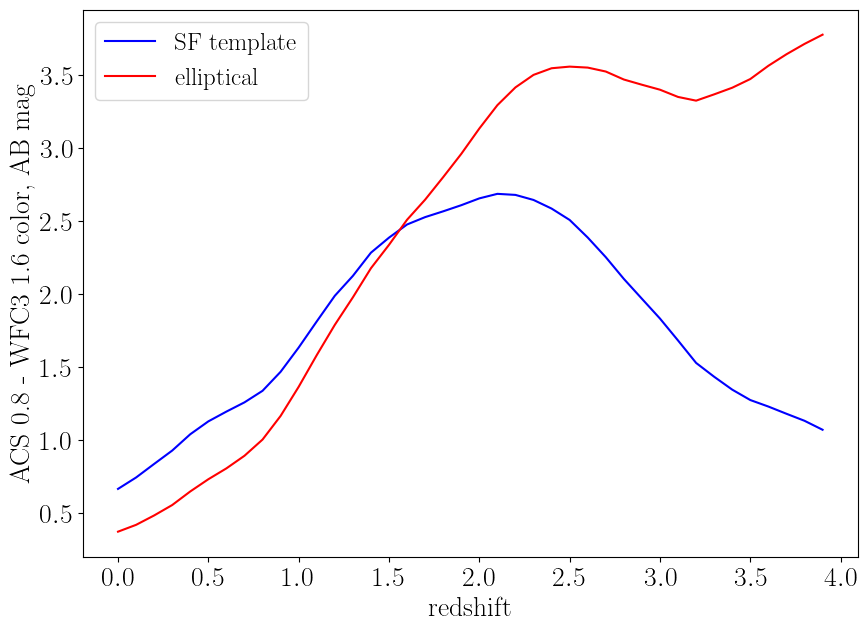

In [5]:
plt.plot(z,color_sf,color='blue',label='SF template')
plt.plot(z,color_ell,color='red',label='elliptical')
plt.legend(loc='upper left')
plt.xlabel('redshift')
plt.ylabel('ACS 0.8 - WFC3 1.6 color, AB mag')
plt.show()

<h1>Example 3: Showing average f_lambda on top of the spectrum</h1>

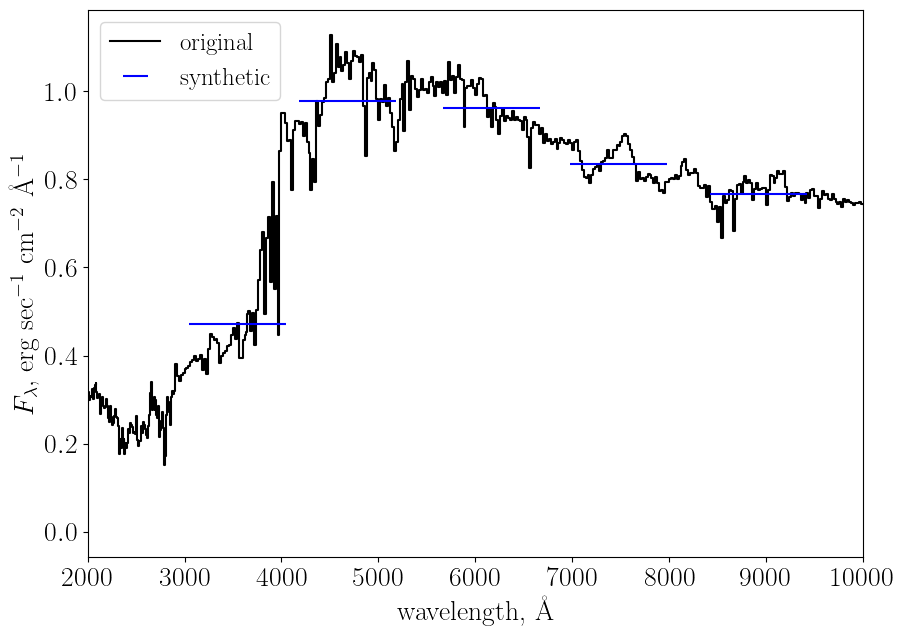

In [6]:
# let's show an example
data = ascii.read("SWIRE/Arp220_template_norm.sed") 
# SWIRE readme file states that the first column is wavelength in Angstroms and the second is flux density Flambda
data.rename_column('col1', 'wv')
data.rename_column('col2', 'flambda')
# load SDSS filter curves
sdss_u=ascii.read("FIL_CURVE/filter_sdss_u.dat")
sdss_g=ascii.read("FIL_CURVE/filter_sdss_g.dat")
sdss_r=ascii.read("FIL_CURVE/filter_sdss_r.dat")
sdss_i=ascii.read("FIL_CURVE/filter_sdss_i.dat")
sdss_z=ascii.read("FIL_CURVE/filter_sdss_z.dat")
eff_lam=np.array([3551., 4686., 6166., 7480., 8923.])
eff_flam=np.zeros(len(eff_lam))

# let's show the original spectrum and the computed synthetic averages
plt.step(data['wv'],data['flambda'],where='mid',color='black',label='original')
eff_flam[0]=flam_ave(data['wv'],data['flambda'],sdss_u['col1'],sdss_u['col2'],tflag=1,verbose=0)
eff_flam[1]=flam_ave(data['wv'],data['flambda'],sdss_g['col1'],sdss_g['col2'],tflag=1,verbose=0)
eff_flam[2]=flam_ave(data['wv'],data['flambda'],sdss_r['col1'],sdss_r['col2'],tflag=1,verbose=0)
eff_flam[3]=flam_ave(data['wv'],data['flambda'],sdss_i['col1'],sdss_i['col2'],tflag=1,verbose=0)
eff_flam[4]=flam_ave(data['wv'],data['flambda'],sdss_z['col1'],sdss_z['col2'],tflag=1,verbose=0)

# the widths of the filters are not properly taken into account, this is just for display purposes
# to demonstrate agreement between input flambda and averaged computed flambda
plt.errorbar(eff_lam, eff_flam, xerr=500, ls='none', color='blue', label='synthetic')
plt.xlim((2000,10000))
plt.legend(loc='upper left')
plt.xlabel(r'wavelength, \AA')
plt.ylabel(r'$F_{\lambda}$, erg sec$^{-1}$ cm$^{-2}$ \AA$^{-1}$')
plt.show()

<h1>Example 4: synthetic photometry from the SDSS spectrum of a white dwarf</h1>

In [7]:
hdu = fits.open("EXAMPLES/spec-4180-55679-0384.fits") 
#hdu.info()
data=hdu[1].data
hdu.close()

In [8]:
# the two relevant columns in the data are data['loglam'] and data['flux']
wv=10**data['loglam']
# data['flux'] is f_lambda in units of 1e-17 erg/sec/cm2/A, which we need to translate into physical units
fnu=data['flux']*wv**2*1e-8*1e-17/(3e10*1e-23)
# ok, here one factor of 1e-8 is to convert A to cm, 1e-17 is to account for the Sloan flambda units, 3e10 is
# the speed of light and 1e-23 is to convert to Janskys, so this flux density is in Janskys

# load SDSS filter curves
sdss_u=ascii.read("FIL_CURVE/filter_sdss_u.dat")
sdss_g=ascii.read("FIL_CURVE/filter_sdss_g.dat")
sdss_r=ascii.read("FIL_CURVE/filter_sdss_r.dat")
sdss_i=ascii.read("FIL_CURVE/filter_sdss_i.dat")
sdss_z=ascii.read("FIL_CURVE/filter_sdss_z.dat")

eff_fnu=np.zeros(5)
# compute average fnu
eff_fnu[0]=flam_ave(wv,fnu,sdss_u['col1'],sdss_u['col2'],tflag=1,verbose=0)
eff_fnu[1]=flam_ave(wv,fnu,sdss_g['col1'],sdss_g['col2'],tflag=1,verbose=0)
eff_fnu[2]=flam_ave(wv,fnu,sdss_r['col1'],sdss_r['col2'],tflag=1,verbose=0)
eff_fnu[3]=flam_ave(wv,fnu,sdss_i['col1'],sdss_i['col2'],tflag=1,verbose=0)
eff_fnu[4]=flam_ave(wv,fnu,sdss_z['col1'],sdss_z['col2'],tflag=1,verbose=0)
# this fnu is in Janskys, therefore AB magnitudes are
abmag=-2.5*np.log10(eff_fnu/3631.)
print(abmag)
# [17.69706269 16.91746829 17.04999113 17.20676252 17.42253118]

[17.69706258 16.91746826 17.04999115 17.20676253 17.42253118]


For comparison, this is the actual photometry of this source:
    ![photometry](EXAMPLES/sdss_photometry.png)
    
The agreement is excellent in the griz bands, but in the u-band the spectrum gives a fainter AB magnitude than the actual photometry. That's because the SDSS spectrum does not cover the entire u band and we are missing flux that's falling into this band. 

<h1>Example 5: calculate effective wavelength of a filter</h1>

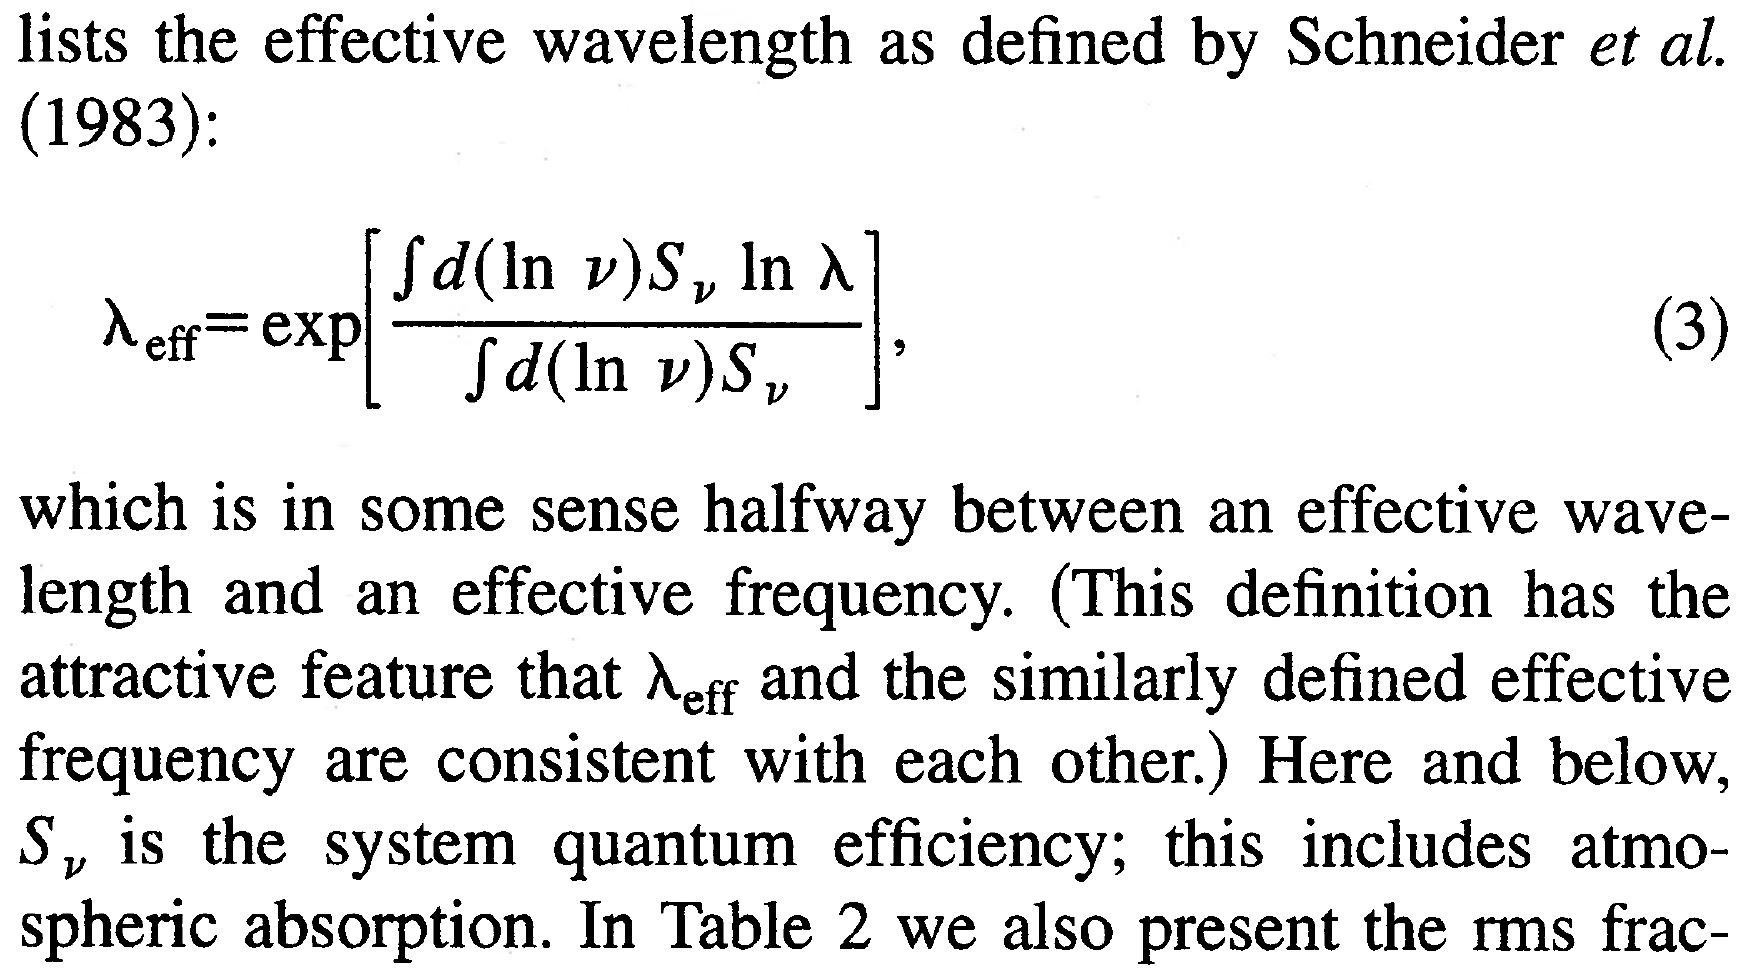

In [9]:
# we are coding this equation from Fukugita et al. 1996 -- this is not the same definition as some other definitions
# for example the definition on http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Generic/Johnson.I&&mode=browse&gname=Generic&gname2=Johnson#filter 
# is different. 
from IPython.display import Image
from IPython.core.display import HTML 
Image("EXAMPLES/fukugita_1996.png", width=400)


In [10]:
johnson_v=ascii.read('FIL_CURVE/Generic_Johnson.V.dat')
lam_eff(johnson_v['col1'], johnson_v['col2'])
# returns 5501, which is a little higher than the two values provided using other definitions


5501.2337666428775